# Stroke Classification

In [23]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import matplotlib.pyplot as plt
from sklearn import tree

## Data cleaning and prep

In [2]:
stroke_df = pd.read_csv("healthcare-dataset-stroke-data.csv")
stroke_df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [3]:
# make a copy so we keep the original data untouched
stroke_copy = stroke_df.copy()

In [4]:
#with na's dropped we hardly lose data so we decided to just drop NA's
stroke_copy.dropna()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5104,14180,Female,13.0,0,0,No,children,Rural,103.08,18.6,Unknown,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [5]:
#The id column is irrelevant so just decided to drop it.
stroke_copy = stroke_copy.drop(columns=['id'])

In [6]:
stroke_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


### One Hot Encoding to prep data for modeling.

In [8]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype='int')

In [9]:
categorical_columns = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

In [10]:
numerical_columns = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']

In [13]:
stroke_categorical = stroke_copy[categorical_columns]
stroke_numerical = stroke_copy[numerical_columns]

In [15]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype='int')
stroke_categorical = pd.DataFrame(data=ohe.fit_transform(stroke_categorical), 
                                           columns=ohe.get_feature_names_out(categorical_columns))

In [16]:
stroke_encoded = pd.concat([stroke_numerical.reset_index(drop=True), stroke_categorical.reset_index(drop=True)], axis=1)
stroke_encoded.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,gender_Other,ever_married_No,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,1,0,1,0,0,...,0,1,0,0,0,1,0,1,0,0
1,61.0,0,0,202.21,NaN,1,1,0,0,0,...,0,0,1,0,1,0,0,0,1,0
2,80.0,0,1,105.92,32.5,1,0,1,0,0,...,0,1,0,0,1,0,0,0,1,0
3,49.0,0,0,171.23,34.4,1,1,0,0,0,...,0,1,0,0,0,1,0,0,0,1
4,79.0,1,0,174.12,24.0,1,1,0,0,0,...,0,0,1,0,1,0,0,0,1,0


In [17]:
X = stroke_encoded.drop(columns = 'stroke')
y = stroke_encoded['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [18]:
X_train.isna().sum()/len(stroke_encoded)

age                               0.000000
hypertension                      0.000000
heart_disease                     0.000000
avg_glucose_level                 0.000000
bmi                               0.029354
gender_Female                     0.000000
gender_Male                       0.000000
gender_Other                      0.000000
ever_married_No                   0.000000
ever_married_Yes                  0.000000
work_type_Govt_job                0.000000
work_type_Never_worked            0.000000
work_type_Private                 0.000000
work_type_Self-employed           0.000000
work_type_children                0.000000
Residence_type_Rural              0.000000
Residence_type_Urban              0.000000
smoking_status_Unknown            0.000000
smoking_status_formerly smoked    0.000000
smoking_status_never smoked       0.000000
smoking_status_smokes             0.000000
dtype: float64

In [19]:
clf = RandomForestClassifier(random_state=1, n_estimators=500).fit(X_train, y_train)

# Evaluate the model
print(f'Training Score: {clf.score(X_train, y_train)}')
print(f'Testing Score: {clf.score(X_test, y_test)}')

Training Score: 1.0
Testing Score: 0.9475743348982786


In [20]:
feature_importances = clf.feature_importances_

In [21]:
importances_sorted = sorted(zip(feature_importances, X.columns), reverse=True)
importances_sorted[:10]

[(0.25636133664155497, 'avg_glucose_level'),
 (0.24193354172514142, 'age'),
 (0.22937579954010945, 'bmi'),
 (0.025176694397699807, 'heart_disease'),
 (0.025015605490482817, 'hypertension'),
 (0.020605512349366115, 'work_type_Private'),
 (0.02056104321383769, 'smoking_status_never smoked'),
 (0.019512128814341546, 'Residence_type_Urban'),
 (0.019098440042544334, 'work_type_Self-employed'),
 (0.018751371021416163, 'Residence_type_Rural')]

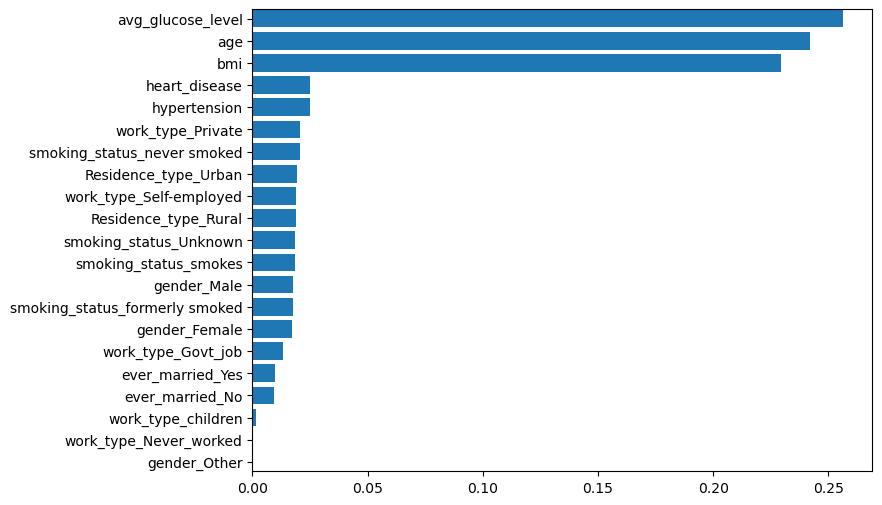

In [22]:
# Plot the feature importances
features = sorted(zip(X.columns, feature_importances), key = lambda x: x[1])
cols = [f[0] for f in features]
width = [f[1] for f in features]

fig, ax = plt.subplots()

fig.set_size_inches(8,6)
plt.margins(y=0.001)

ax.barh(y=cols, width=width)

plt.show()